In [3]:
from alex_net.model import AlexNet
from alex_net.utils import get_model_params
import matplotlib.pyplot as plt
import torch

In [4]:
params = get_model_params('alexnet', override_params={'num_classes': 10})
model = AlexNet(params)
pretrained_weights = torch.load('alex_net/pretrained_model.pth.tar')
model.load_state_dict(pretrained_weights['state_dict'])

<All keys matched successfully>

In [5]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
type(model.features[0].weight.data) 
# --> torch.Tensor 

kernels = model.features[0].weight.data
kernels.shape
# --> torch.Size([64, 3, 11, 11])

reshaped_kernels = kernels.view(-1, 11, 11)
reshaped_kernels.shape
# --> torch.Size([192, 11, 11])

avg_kernels_over_rgb = torch.mean(kernels, dim=1)
avg_kernels_over_rgb.shape
# --> torch.Size([64, 11, 11])

torch.Size([64, 11, 11])

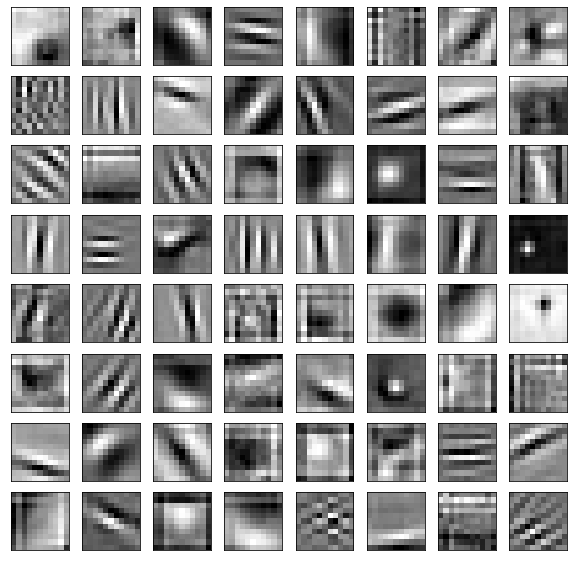

In [18]:
fig, ax = plt.subplots(8,8, figsize=(10,10))
k = 0
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(model.features[0].weight.data[k,0,:,:], cmap='gray')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        k += 1
plt.show()

In [28]:
import rasterio
from rasterio.windows import Window
import numpy as np

with rasterio.open('../data/UH_NAD83_272056_3289689.tif') as img:
    print(img.shape)
    window = Window(300, 300, 600, 600)
    data = img.read(window=window)
data = data.transpose(1, 2, 0)

(12020, 11920)


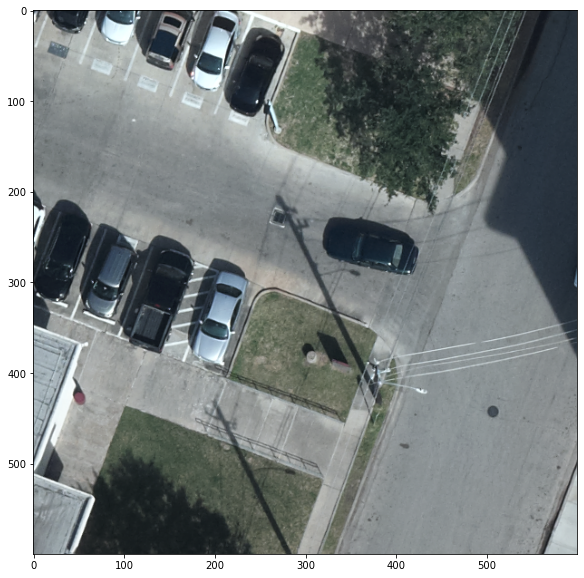

In [29]:
fig = plt.figure(figsize=(10,10))
plt.imshow(data)
plt.show()